In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
seed = 2724

### Import data

In [3]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [4]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [6]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=2724)

### Use SHAP to explain the model on test data

In [7]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 99%|===================| 1487/1500 [00:38<00:00]        

This will allow us to see which variables are most important to predicting the outcome.

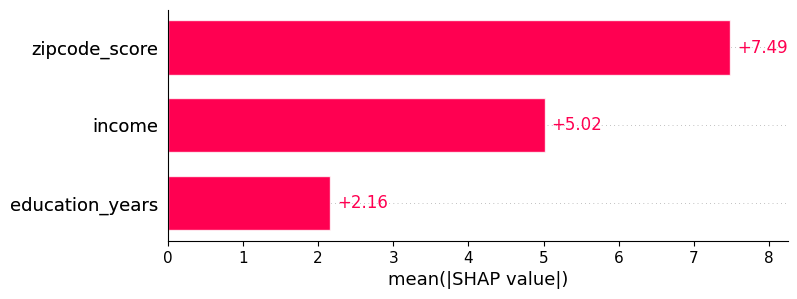

In [8]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [9]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [10]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.086254,-0.170779,5.866534
1,1.020094,-0.192841,-6.859435


### Let's put `group` and `zipcode_score` in the same plot

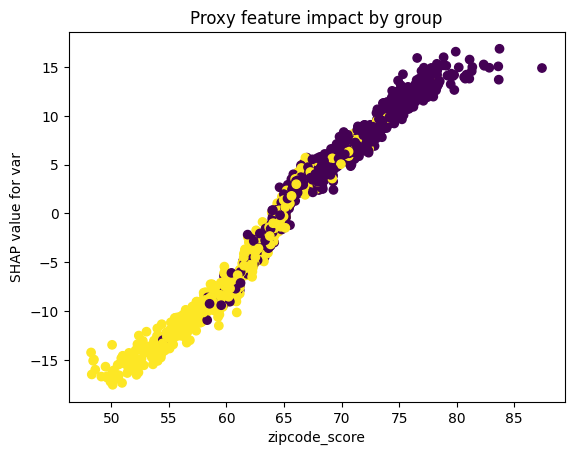

In [11]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

A SHAP value shows how much one feature impacts a prediction for a single data point. It tells you if that feature is pushing the prediction higher or lower compared to the average prediction. Basically, it helps explain what is driving the model’s decision.

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

If the reviewer asks whether I used the variable group in the model, my answer would be no. The model was trained only using income, education_years, and zipcode_score. The group variable was not used when training the model. I only added it later to compare SHAP values between the two groups.

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

If the reviewer asks whether the outocme of the model is correlated with group, I would say yes. When I looked at the average SHAP values by group, income and education were very similar between the two groups. The differences were small. But for zipcode_score, the difference was huge, one group had a strong positive impact, and the other had a strong negative impact. This tells me zipcode_score is probably correlated with group and is acting like a proxy variable. Even though group was not included in the model, the predictions still end up being different because of zipcode_score.

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

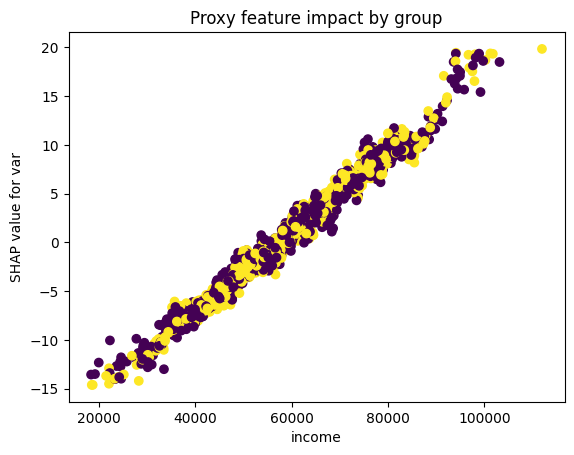

In [12]:
plot_shap("income")

When I plotted income, the points from both groups were mostly overlapping. The colors were mixed, which means income affects both groups pretty similarly. But for zipcode_score, the groups were clearly separated. One group mostly had positive SHAP values and the other had negative ones. That shows zipcode_score is acting like a strong proxy, while income is not.

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

If I were the reviewer, I would ask how strongly zipcode_score is tied to protected attributes, whether fairness metrics show differences between groups, and if one group has more prediction errors. Another question that I would also ask would be whether or not zipcode_score should be removed or adjusted.